<a href="https://www.kaggle.com/code/klyushnik/episode-10?scriptVersionId=168374992" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pulsar-classification-for-class-prediction/Pulsar.csv
/kaggle/input/playground-series-s3e10/sample_submission.csv
/kaggle/input/playground-series-s3e10/train.csv
/kaggle/input/playground-series-s3e10/test.csv


# Load data

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s3e10/train.csv')
original = pd.read_csv('/kaggle/input/pulsar-classification-for-class-prediction/Pulsar.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e10/test.csv')
train = pd.concat([train.drop(columns=['id']), original], ignore_index=True)

# Load libraries

In [3]:
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image
%matplotlib inline
!pip install joypy
import joypy as joypy

import random
import os
from copy import deepcopy
from functools import partial
from itertools import combinations
import sklearn.svm
import itertools
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_sample_weight

import pickle

from sklearn.decomposition import PCA

# Import sklearn classes for model selection, cross validation, and performance evaluation
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score, accuracy_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
import seaborn as sns
from category_encoders import OneHotEncoder, OrdinalEncoder, CountEncoder

# Import libraries for Hypertuning
import optuna

# Import libraries for gradient boosting
import xgboost as xgb
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoost,  CatBoostClassifier
import catboost as cat
from sklearn.model_selection import train_test_split
from sklearn.isotonic import IsotonicRegression

from sklearn.ensemble import StackingClassifier, HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from catboost import Pool

from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from matplotlib import pyplot

# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Pandas Profiling

In [4]:
pandas_profiling.ProfileReport(train)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Plot links

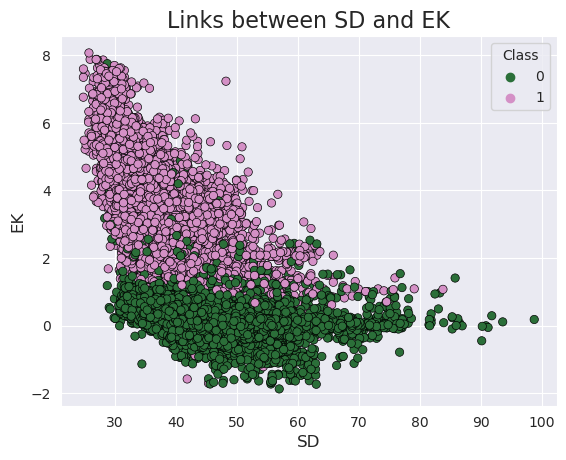

In [5]:
sns.set_style('darkgrid')
plt.title('Links between SD and EK',size=16)
plt.xlabel('SD',size=12)
plt.ylabel('EK',size=12)
sns.scatterplot(x='SD', y='EK', data=train, hue='Class', edgecolor='black', palette='cubehelix')
plt.show()

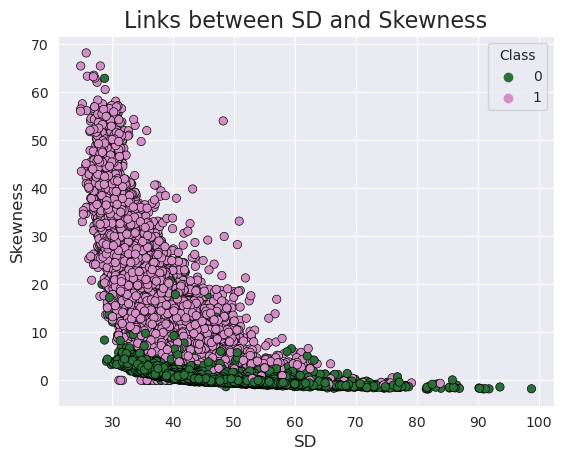

In [6]:
sns.set_style('darkgrid')
plt.title('Links between SD and Skewness',size=16)
plt.xlabel('SD',size=12)
plt.ylabel('Skewness',size=12)
sns.scatterplot(x='SD', y='Skewness', data=train, hue='Class', edgecolor='black', palette='cubehelix')
plt.show()

<Figure size 1280x800 with 0 Axes>

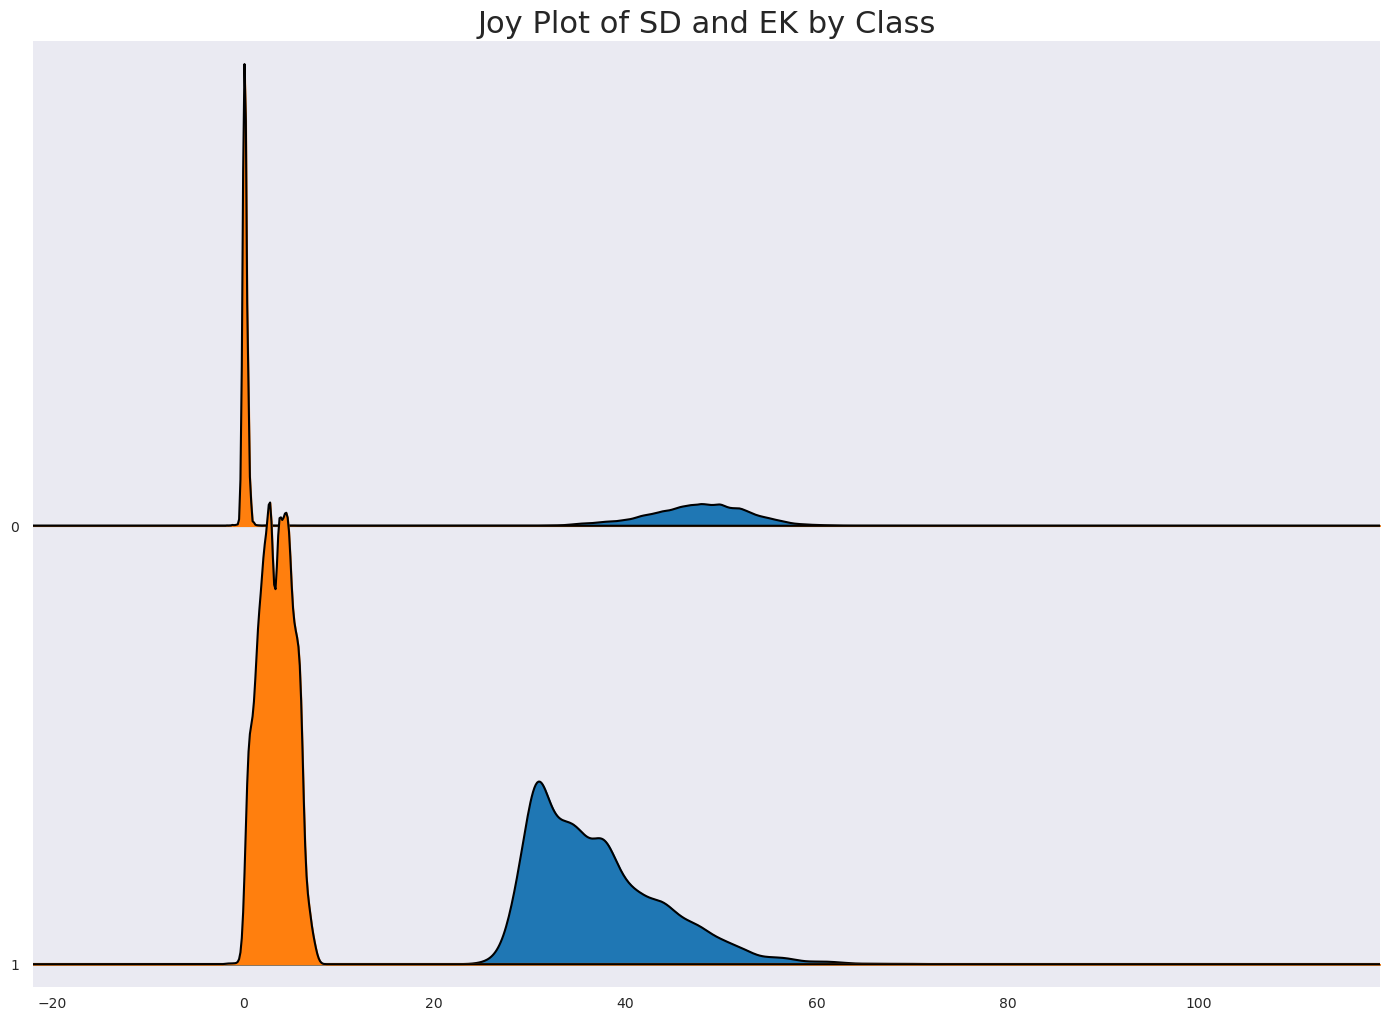

In [7]:
plt.figure(figsize=(16,10), dpi= 80)
fig, axes = joypy.joyplot(train, column=['SD', 'EK'], by="Class", ylim='own', figsize=(14,10))

# Decoration
plt.title('Joy Plot of SD and EK by Class', fontsize=22)
plt.show()

**Drop nan**

In [8]:
train = train.fillna(0)
test = test.fillna(0)

**Drop quantile**

In [9]:
def outlier_removal(data , i):
    q1 = np.quantile(data[i] ,0.25)
    q3 = np.quantile(data[i] , 0.75)
    iqr = q3-q1
    lower_tail = q1 - 1.5*iqr
    upper_tail = q3 + 1.5*iqr
    data.drop(data[data[i]> upper_tail].index , inplace = True)
    data.drop(data[data[i]< lower_tail].index ,inplace =True)
    
outlier_list = ['Mean_Integrated', 'SD', 'EK', 'Skewness', 'Mean_DMSNR_Curve',
       'SD_DMSNR_Curve', 'EK_DMSNR_Curve', 'Skewness_DMSNR_Curve']
for  i in outlier_list:
    outlier_removal(train ,i)

# Data marking

In [10]:
target_col = 'Class'
X = train.drop(['Class'],axis=1).reset_index(drop=True)
y = train['Class'].reset_index(drop=True)
X_total = test.drop(['id'], axis = 1).reset_index(drop=True)

print(f"X_train shape :{X.shape} , y_train shape :{y.shape}")
print(f"X_test shape :{X_total.shape}")

X_train shape :(91476, 8) , y_train shape :(91476,)
X_test shape :(78377, 8)


# Aggregate Featrues

In [11]:
class AggFeatureExtractor(BaseEstimator, TransformerMixin):
    
    def __init__(self, group_col, agg_col, agg_func):
        self.group_col = group_col
        self.group_col_name = ''
        for col in group_col:
            self.group_col_name += col
        self.agg_col = agg_col
        self.agg_func = agg_func
        self.agg_df = None
        self.medians = None
        
    def fit(self, X, y=None):
        group_col = self.group_col
        agg_col = self.agg_col
        agg_func = self.agg_func
        
        self.agg_df = X.groupby(group_col)[agg_col].agg(agg_func)
        self.agg_df.columns = [f'{self.group_col_name}_{agg}_{_agg_col}' for _agg_col in agg_col for agg in agg_func]
        self.medians = X[agg_col].median()
        
        return self
    
    def transform(self, X):
        group_col = self.group_col
        agg_col = self.agg_col
        agg_func = self.agg_func
        agg_df = self.agg_df
        medians = self.medians
        
        X_merged = pd.merge(X, agg_df, left_on=group_col, right_index=True, how='left')
        X_merged.fillna(medians, inplace=True)
        X_agg = X_merged.loc[:, [f'{self.group_col_name}_{agg}_{_agg_col}' for _agg_col in agg_col for agg in agg_func]]
        
        return X_agg
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        X_agg = self.transform(X)
        return X_agg

In [12]:
class Preprocessor:
    def __init__(self, agg_col, agg_func, group_cols):
        self.agg_col = agg_col
        self.agg_func = agg_func
        self.group_cols = group_cols
        
    def preprocess(self, X, X_total):        
        agg_train, agg_test = [], []
        for group_col in self.group_cols:
            agg_extractor = AggFeatureExtractor(group_col=group_col, agg_col=self.agg_col, agg_func=self.agg_func)
            agg_extractor.fit(pd.concat([X, X_total], axis=0))
            agg_train.append(agg_extractor.transform(X))
            agg_test.append(agg_extractor.transform(X_total))
        X = pd.concat([X] + agg_train, axis=1)
        X_total = pd.concat([X_total] + agg_test, axis=1)
        
        X = X.fillna(0)
        X_total = X_total.fillna(0)
       
        
        return X, X_total   

In [13]:
agg_col = ['SD', 'EK', 'Skewness', 'SD_DMSNR_Curve', 'EK_DMSNR_Curve', 'Skewness_DMSNR_Curve']

agg_func = ['mean', 'std']
group_cols = [['SD'], ['EK'], ['Skewness'], 
              ['SD', 'EK'], ['SD', 'Skewness'], 
              ['EK', 'Skewness'], 
              ['SD', 'EK', 'Skewness']]

pp = Preprocessor(agg_col, agg_func, group_cols)
X, X_total = pp.preprocess(X, X_total)

print(f"X_train shape :{X.shape} , y_train shape :{y.shape}")
print(f"X_test shape :{X_total.shape}")

X_train shape :(91476, 92) , y_train shape :(91476,)
X_test shape :(78377, 92)


# Slit train, test

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)

# CatBoostClassifier

In [15]:
def objective(trial):
    model = CatBoostClassifier(
        iterations=trial.suggest_int("iterations", 100, 1000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        verbose=False
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-03-23 05:10:04,743] A new study created in memory with name: no-name-97c6e7b3-8bf6-4602-9655-076f67b911c4
[I 2024-03-23 05:11:51,212] Trial 0 finished with value: 0.9975404459991255 and parameters: {'iterations': 509, 'learning_rate': 0.049526404289384374, 'depth': 10, 'l2_leaf_reg': 0.005430202900761044, 'bootstrap_type': 'Bayesian', 'random_strength': 8.291598266955894e-07, 'bagging_temperature': 3.2346909078546746, 'od_type': 'Iter', 'od_wait': 36}. Best is trial 0 with value: 0.9975404459991255.
[I 2024-03-23 05:12:16,429] Trial 1 finished with value: 0.9975404459991255 and parameters: {'iterations': 916, 'learning_rate': 0.011697490904933548, 'depth': 5, 'l2_leaf_reg': 0.5225745069920675, 'bootstrap_type': 'Bayesian', 'random_strength': 0.06410885378728076, 'bagging_temperature': 0.7087689235658923, 'od_type': 'Iter', 'od_wait': 19}. Best is trial 0 with value: 0.9975404459991255.
Training has stopped (degenerate solution on iteration 319, probably too small l2-regularizat

Number of finished trials: 10
Best trial:
  Value: 0.9975404459991255
  Params: 
    iterations: 509
    learning_rate: 0.049526404289384374
    depth: 10
    l2_leaf_reg: 0.005430202900761044
    bootstrap_type: Bayesian
    random_strength: 8.291598266955894e-07
    bagging_temperature: 3.2346909078546746
    od_type: Iter
    od_wait: 36


In [16]:
param_cat  = study.best_params
param_cat

{'iterations': 509,
 'learning_rate': 0.049526404289384374,
 'depth': 10,
 'l2_leaf_reg': 0.005430202900761044,
 'bootstrap_type': 'Bayesian',
 'random_strength': 8.291598266955894e-07,
 'bagging_temperature': 3.2346909078546746,
 'od_type': 'Iter',
 'od_wait': 36}

# XGB

In [17]:
train_y_label = y_train
valid_y_label = y_test
train_x_tr, valid_x_es, train_y_tr, valid_y_es = train_test_split(X_train, train_y_label, test_size=0.2)

dtrain = xgb.DMatrix(train_x_tr, label=train_y_tr)
dtest = xgb.DMatrix(X_test, label=valid_y_label)

def objective(trial):

    param = {
        "verbosity": 0,
        "objective": "multi:softmax",
        "num_class": 5,
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "early_stopping_rounds":200,
        "evals":([valid_x_es,valid_y_es])
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dtest)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(valid_y_label, pred_labels)
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10, timeout=600)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-03-23 05:17:34,890] A new study created in memory with name: no-name-80889511-503f-4720-a34f-791b37c1c2db
[I 2024-03-23 05:17:38,678] Trial 0 finished with value: 0.9975404459991255 and parameters: {'booster': 'gbtree', 'lambda': 0.13748896366759825, 'alpha': 0.3065828294448248, 'subsample': 0.7513724191055331, 'colsample_bytree': 0.8373372636850995, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.06162340879312946, 'gamma': 1.5264347656444123e-08, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.9975404459991255.
[I 2024-03-23 05:17:40,433] Trial 1 finished with value: 0.9975404459991255 and parameters: {'booster': 'gbtree', 'lambda': 0.441378821169778, 'alpha': 0.034836954770123246, 'subsample': 0.3067782856572041, 'colsample_bytree': 0.5683987947296726, 'max_depth': 7, 'min_child_weight': 8, 'eta': 2.830922651067654e-07, 'gamma': 5.2625009628984876e-06, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.9975404459991255.
[I 2024-03-23 05:17:47,104] Trial 2 

Number of finished trials: 10
Best trial:
  Value: 0.9975404459991255
  Params: 
    booster: gbtree
    lambda: 0.13748896366759825
    alpha: 0.3065828294448248
    subsample: 0.7513724191055331
    colsample_bytree: 0.8373372636850995
    max_depth: 9
    min_child_weight: 7
    eta: 0.06162340879312946
    gamma: 1.5264347656444123e-08
    grow_policy: lossguide


In [18]:
param_xgb = study.best_params
param_xgb

{'booster': 'gbtree',
 'lambda': 0.13748896366759825,
 'alpha': 0.3065828294448248,
 'subsample': 0.7513724191055331,
 'colsample_bytree': 0.8373372636850995,
 'max_depth': 9,
 'min_child_weight': 7,
 'eta': 0.06162340879312946,
 'gamma': 1.5264347656444123e-08,
 'grow_policy': 'lossguide'}

# LGB

In [19]:
train_y_label = y_train
valid_y_label = y_test
dtrain = lgb.Dataset(X_train, label=train_y_label)

# FYI: Objective functions can take additional arguments
# (https://optuna.readthedocs.io/en/stable/faq.html#objective-func-additional-args).
def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'feature_pre_filter' : False
    }

    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(X_test)
    pred_labels = []
    for i in range(0,len(preds)):
        pred_labels.append(np.argmax(preds[i]))
    accuracy = cal_acc(valid_y_label, pred_labels)
    return accuracy

def cal_acc(true, pred):
    return np.mean(true==pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-03-23 05:18:11,552] A new study created in memory with name: no-name-52f056c4-33e3-4794-85f1-7c7c478a6db2


[LightGBM] [Info] Number of positive: 152, number of negative: 73028
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17833
[LightGBM] [Info] Number of data points in the train set: 73180, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002077 -> initscore=-6.174718
[LightGBM] [Info] Start training from score -6.174718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2024-03-23 05:18:15,842] Trial 0 finished with value: 0.9975404459991255 and parameters: {'lambda_l1': 9.312315503707938e-07, 'lambda_l2': 0.0010828078095622025, 'num_leaves': 234, 'feature_fraction': 0.4062935357122956, 'bagging_fraction': 0.46714559636432024, 'bagging_freq': 1, 'min_child_samples': 62}. Best is trial 0 with value: 0.9975404459991255.


[LightGBM] [Info] Number of positive: 152, number of negative: 73028
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17833
[LightGBM] [Info] Number of data points in the train set: 73180, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002077 -> initscore=-6.174718
[LightGBM] [Info] Start training from score -6.174718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2024-03-23 05:18:20,936] Trial 1 finished with value: 0.9975404459991255 and parameters: {'lambda_l1': 0.00024545639713976266, 'lambda_l2': 2.3977959527925415e-06, 'num_leaves': 140, 'feature_fraction': 0.575002696569445, 'bagging_fraction': 0.6189146123042442, 'bagging_freq': 4, 'min_child_samples': 11}. Best is trial 0 with value: 0.9975404459991255.


[LightGBM] [Info] Number of positive: 152, number of negative: 73028
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17833
[LightGBM] [Info] Number of data points in the train set: 73180, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002077 -> initscore=-6.174718
[LightGBM] [Info] Start training from score -6.174718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2024-03-23 05:18:29,326] Trial 2 finished with value: 0.9975404459991255 and parameters: {'lambda_l1': 8.197380629774965e-07, 'lambda_l2': 1.8970478416649817e-06, 'num_leaves': 245, 'feature_fraction': 0.787327246222093, 'bagging_fraction': 0.8471093475602776, 'bagging_freq': 6, 'min_child_samples': 77}. Best is trial 0 with value: 0.9975404459991255.


[LightGBM] [Info] Number of positive: 152, number of negative: 73028
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17833
[LightGBM] [Info] Number of data points in the train set: 73180, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002077 -> initscore=-6.174718
[LightGBM] [Info] Start training from score -6.174718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2024-03-23 05:18:32,630] Trial 3 finished with value: 0.9975404459991255 and parameters: {'lambda_l1': 2.094515118760061e-08, 'lambda_l2': 0.10524657617472594, 'num_leaves': 190, 'feature_fraction': 0.9153216862275468, 'bagging_fraction': 0.4861553688588267, 'bagging_freq': 6, 'min_child_samples': 54}. Best is trial 0 with value: 0.9975404459991255.


[LightGBM] [Info] Number of positive: 152, number of negative: 73028
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17833
[LightGBM] [Info] Number of data points in the train set: 73180, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002077 -> initscore=-6.174718
[LightGBM] [Info] Start training from score -6.174718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2024-03-23 05:18:35,976] Trial 4 finished with value: 0.9975404459991255 and parameters: {'lambda_l1': 1.9167283842468166, 'lambda_l2': 1.7703652707760037e-08, 'num_leaves': 167, 'feature_fraction': 0.8021248909955914, 'bagging_fraction': 0.912822979663367, 'bagging_freq': 4, 'min_child_samples': 10}. Best is trial 0 with value: 0.9975404459991255.


[LightGBM] [Info] Number of positive: 152, number of negative: 73028
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17833
[LightGBM] [Info] Number of data points in the train set: 73180, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002077 -> initscore=-6.174718
[LightGBM] [Info] Start training from score -6.174718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2024-03-23 05:18:41,159] Trial 5 finished with value: 0.9975404459991255 and parameters: {'lambda_l1': 2.6646454472804967e-06, 'lambda_l2': 0.00014971791318362955, 'num_leaves': 84, 'feature_fraction': 0.9236469531296261, 'bagging_fraction': 0.5584528301407379, 'bagging_freq': 2, 'min_child_samples': 26}. Best is trial 0 with value: 0.9975404459991255.


[LightGBM] [Info] Number of positive: 152, number of negative: 73028
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17833
[LightGBM] [Info] Number of data points in the train set: 73180, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002077 -> initscore=-6.174718
[LightGBM] [Info] Start training from score -6.174718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2024-03-23 05:18:46,841] Trial 6 finished with value: 0.9975404459991255 and parameters: {'lambda_l1': 1.8945250419692333e-05, 'lambda_l2': 5.184982232939651e-06, 'num_leaves': 124, 'feature_fraction': 0.7477711585877719, 'bagging_fraction': 0.8177661352057781, 'bagging_freq': 5, 'min_child_samples': 97}. Best is trial 0 with value: 0.9975404459991255.


[LightGBM] [Info] Number of positive: 152, number of negative: 73028
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040749 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17833
[LightGBM] [Info] Number of data points in the train set: 73180, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002077 -> initscore=-6.174718
[LightGBM] [Info] Start training from score -6.174718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2024-03-23 05:18:50,766] Trial 7 finished with value: 0.9975404459991255 and parameters: {'lambda_l1': 0.20788852343762754, 'lambda_l2': 0.00035919187843950085, 'num_leaves': 73, 'feature_fraction': 0.6126367021670509, 'bagging_fraction': 0.926020974420235, 'bagging_freq': 3, 'min_child_samples': 80}. Best is trial 0 with value: 0.9975404459991255.


[LightGBM] [Info] Number of positive: 152, number of negative: 73028
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17833
[LightGBM] [Info] Number of data points in the train set: 73180, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002077 -> initscore=-6.174718
[LightGBM] [Info] Start training from score -6.174718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2024-03-23 05:18:57,701] Trial 8 finished with value: 0.9975404459991255 and parameters: {'lambda_l1': 3.131724156872059e-05, 'lambda_l2': 9.338123429059215e-05, 'num_leaves': 140, 'feature_fraction': 0.5555675984533174, 'bagging_fraction': 0.844221421627436, 'bagging_freq': 5, 'min_child_samples': 24}. Best is trial 0 with value: 0.9975404459991255.


[LightGBM] [Info] Number of positive: 152, number of negative: 73028
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17833
[LightGBM] [Info] Number of data points in the train set: 73180, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002077 -> initscore=-6.174718
[LightGBM] [Info] Start training from score -6.174718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2024-03-23 05:19:01,386] Trial 9 finished with value: 0.9975404459991255 and parameters: {'lambda_l1': 2.8187957133757186e-05, 'lambda_l2': 0.009277566156328004, 'num_leaves': 117, 'feature_fraction': 0.5290433315214844, 'bagging_fraction': 0.4194976288738788, 'bagging_freq': 3, 'min_child_samples': 16}. Best is trial 0 with value: 0.9975404459991255.


Number of finished trials: 10
Best trial:
  Value: 0.9975404459991255
  Params: 
    lambda_l1: 9.312315503707938e-07
    lambda_l2: 0.0010828078095622025
    num_leaves: 234
    feature_fraction: 0.4062935357122956
    bagging_fraction: 0.46714559636432024
    bagging_freq: 1
    min_child_samples: 62


In [20]:
param_lgb = study.best_params
param_lgb

{'lambda_l1': 9.312315503707938e-07,
 'lambda_l2': 0.0010828078095622025,
 'num_leaves': 234,
 'feature_fraction': 0.4062935357122956,
 'bagging_fraction': 0.46714559636432024,
 'bagging_freq': 1,
 'min_child_samples': 62}

# Compare classifiers

In [21]:
FOLDS=5
seed = 42
np.random.seed(seed)
predictions_cat, scores_cat = np.zeros(len(X_total)), []
k = StratifiedKFold(n_splits=FOLDS, random_state=seed, shuffle=True)
for fold, (train_idx, val_idx) in enumerate(k.split(X, y)):
    
    
    model_cat = CatBoostClassifier(**param_cat, verbose = 0)
    model_cat.fit(X.iloc[train_idx],y.iloc[train_idx],
                                     eval_set=(X.iloc[val_idx], y.iloc[val_idx]),plot=False)
    
    valid_pred_cat = model_cat.predict_proba(X.iloc[val_idx])[:,1]
    valid_score = log_loss(y.iloc[val_idx], valid_pred_cat)
    
    predictions_cat += model_cat.predict_proba(X_total)[:,1]/FOLDS
    
    print(f'FOLD {fold+1} | LogLoss: {round(valid_score, 4)}')
    scores_cat.append(valid_score)

FOLD 1 | LogLoss: 0.0147
FOLD 2 | LogLoss: 0.0141
FOLD 3 | LogLoss: 0.0145
FOLD 4 | LogLoss: 0.0136
FOLD 5 | LogLoss: 0.014


In [22]:
FOLDS=5
seed = 42
np.random.seed(seed)
predictions_xgb, scores_xbg = np.zeros(len(X_total)), []
k = StratifiedKFold(n_splits=FOLDS, random_state=seed, shuffle=True)
for fold, (train_idx, val_idx) in enumerate(k.split(X, y)):
    
    
    model_xgb = xgb.XGBClassifier(**param_xgb, verbose = 0)
    model_xgb.fit(X.iloc[train_idx],y.iloc[train_idx])
    
    valid_pred_xgb = model_xgb.predict_proba(X.iloc[val_idx])[:,1]
    valid_score = log_loss(y.iloc[val_idx], valid_pred_xgb)
    
    predictions_xgb += model_xgb.predict_proba(X_total)[:,1]/FOLDS
    
    print(f'FOLD {fold+1} | LogLoss: {round(valid_score, 4)}')
    scores_xbg.append(valid_score)

FOLD 1 | LogLoss: 0.0143
FOLD 2 | LogLoss: 0.0134
FOLD 3 | LogLoss: 0.0131
FOLD 4 | LogLoss: 0.0137
FOLD 5 | LogLoss: 0.0134


In [23]:
FOLDS=5
seed = 42
np.random.seed(seed)
predictions_lgb, scores_lgb = np.zeros(len(X_total)), []
k = StratifiedKFold(n_splits=FOLDS, random_state=seed, shuffle=True)
for fold, (train_idx, val_idx) in enumerate(k.split(X, y)):
    
    
    model_lgb = lgb.LGBMClassifier(**param_lgb, verbose = 0)
    model_lgb.fit(X.iloc[train_idx],y.iloc[train_idx])
    
    valid_pred_lgb = model_lgb.predict_proba(X.iloc[val_idx])[:,1]
    valid_score = log_loss(y.iloc[val_idx], valid_pred_lgb)
    
    predictions_lgb += model_lgb.predict_proba(X_total)[:,1]/FOLDS
    
    print(f'FOLD {fold+1} | LogLoss: {round(valid_score, 4)}')
    scores_lgb.append(valid_score)

[LightGBM] [Warning] lambda_l1 is set=9.312315503707938e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.312315503707938e-07
[LightGBM] [Warning] feature_fraction is set=0.4062935357122956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4062935357122956
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.0010828078095622025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010828078095622025
[LightGBM] [Warning] bagging_fraction is set=0.46714559636432024, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46714559636432024
[LightGBM] [Warning] lambda_l1 is set=9.312315503707938e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.312315503707938e-07
[LightGBM] [Warning] feature_fraction is set=0.4062935357122956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4062935357122956
[LightGBM] [Warni

In [24]:
def iso_calib(valid_predictions,valid_target,test_pred):   
    isotonic_reg = IsotonicRegression(out_of_bounds='clip')
    isotonic_reg.fit(valid_predictions,valid_target)
    isotonic_pred_caliberated = isotonic_reg.predict(test_pred)
    return isotonic_pred_caliberated

In [25]:
predictions_lgb = iso_calib(valid_pred_lgb,y.iloc[val_idx],predictions_lgb)
predictions_xgb = iso_calib(valid_pred_xgb,y.iloc[val_idx],predictions_xgb)
predictions_cat = iso_calib(valid_pred_cat,y.iloc[val_idx],predictions_cat)

In [26]:
def norm(preds):
    return (preds - np.min(preds)) / (np.max(preds) - np.min(preds))

sub = pd.read_csv('/kaggle/input/playground-series-s3e10/sample_submission.csv')
sub['Class'] = predictions_xgb + predictions_cat+predictions_lgb
sub

id     Class
0      117564  0.002436
1      117565  0.004106
2      117566  0.001381
3      117567  0.104426
4      117568  0.020474
...       ...       ...
78372  195936  0.002286
78373  195937  0.004106
78374  195938  0.001621
78375  195939  0.058523
78376  195940  0.278139

[78377 rows x 2 columns]

In [27]:
sub.to_csv('submission.csv', index=False)